In [1]:
import pandas as pd
from tqdm import tqdm
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
from citeline.database.milvusdb import MilvusDB
from citeline.embedders import Embedder

tqdm.pandas()

db = MilvusDB()
print(db)
db.list_collections()

Collections:
 - astrobert_chunks: 460801 entities
 - astrobert_contributions: 89860 entities
 - bge_chunks: 460801 entities
 - bge_contributions: 89860 entities
 - nasa_chunks: 460801 entities
 - nasa_contributions: 89860 entities
 - qwen06_chunks: 460801 entities
 - qwen06_contributions: 89860 entities
 - qwen8b_contributions: 89860 entities
 - specter_chunks: 460801 entities
 - specter_contributions: 89860 entities


This notebook takes a jsonl file of 'findings' with schema `{"findings": [str], "doi": str}` and preps a dataset for insertion into Milvus. This requires

1. From the research data used, join to each findings line the:

- citation_count
- pubdate (YYYYMMDD int)

2. Explode the dataframe along findings to get one row per finding
3. Invoke `db.create_collection` with the desired embedder


In [2]:
# Load the research dataset, convert pubdate to YYYYMMDD
research = pd.read_json("../data/preprocessed/research.jsonl", lines=True)
# add index to 'doi' column
research.set_index("doi", inplace=True, verify_integrity=True, drop=False)
research["pubdate"] = research["pubdate"].apply(lambda x: int(x.replace("-", "")))

In [3]:
# Join the findings df with research data expected by db. Explode on 'findings' column which is list[str]
findings = pd.read_json("new_findings.jsonl", lines=True)
findings["citation_count"] = findings.apply(lambda row: research.loc[row["doi"]]["citation_count"], axis=1)
findings["pubdate"] = findings.apply(lambda row: research.loc[row["doi"]]["pubdate"], axis=1)
findings = findings.explode("findings", ignore_index=True)
findings.rename(columns={"findings": "text"}, inplace=True)
findings.head()

,text,doi,citation_count,pubdate
0,"Kepler mission will monitor over 100,000 stars...",10.1111/j.1365-2966.2009.15323.x,44,20091001
1,Kepler Asteroseismic Investigation (KAI) will ...,10.1111/j.1365-2966.2009.15323.x,44,20091001
2,Conservative estimate: ~3000 pixels allocated ...,10.1111/j.1365-2966.2009.15323.x,44,20091001
3,Photometric error for 60-s integration: 45 ppm...,10.1111/j.1365-2966.2009.15323.x,44,20091001
4,Power density error: 0.24 ppm²/μHz at 8th magn...,10.1111/j.1365-2966.2009.15323.x,44,20091001


In [4]:
findings.to_json("findings_for_db.jsonl", lines=True, orient="records")

In [5]:
db.create_vector_collection(
    "qwen06_findings_v2",
    data_source="findings_for_db.jsonl",
    embedder_name="Qwen/Qwen3-Embedding-0.6B",
    normalize=True,
    batch_size=8
)

Creating new collection 'qwen06_findings_v2'...
Collection 'qwen06_findings_v2' created
COLLECTION CREATION SUMMARY
Collection Name     : qwen06_findings_v2
Collection Entities : 0
Num CPUs            : 12
Embedder Name       : Qwen/Qwen3-Embedding-0.6B
Embedder Dimension  : 1024
Normalize           : True
Batch Size          : 8
Device              : mps
Data source         : findings_for_db.jsonl
Data size           : 4342 rows
Using disk flush interval: 512


Embedding: 100%|██████████| 4342/4342 [01:27<00:00, 49.41docs/s]


All insertions complete. Final flush to disk...done!
New collection qwen06_findings_v2: 4342 entities


1. Get the sample set
1. Get the hard examples
1. Get the similarity scores to target and hard examples
1. Using the new prompt, get the scores to the same documents
1. Did the margin improve?

In [6]:
from citeline.query_expander import get_expander
from citeline.embedders import Embedder
embedder = embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True)
expander = get_expander("add_prev_3", path_to_data="../data/preprocessed/reviews.jsonl")
print(embedder)
print(expander)

# Get sample
sample = pd.read_json("../data/dataset/nontrivial_100.jsonl", lines=True)
sample = sample.sample(50, random_state=42).reset_index(drop=True)
sample["sent_no_cit"] = expander(sample)
sample["vector"] = sample.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)
sample.head()

Qwen/Qwen3-Embedding-0.6B, device=mps, normalize=True, dim=1024
QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1146/annurev-astro-081710-102521,Their abundance is important because molecular...,"In this limit, the important reactions are dis...",318,[10.1046/j.1365-8711.2002.04940.x],20110901,[2002MNRAS.329...18F],Their abundance is important because molecular...,"[-0.036558926, -0.016381508, -0.0110567855, 0...."
1,10.1146/annurev-astro-081817-051826,It is important to point out that the fraction...,Gesicki et al. (2014) derived masses and ages ...,231,"[10.1051/0004-6361/201220678, 10.1051/0004-636...",20180901,"[2013A&A...549A.147B, 2017A&A...605A..89B]",It is important to point out that the fraction...,"[-0.016821573, -0.014033405, -0.008635518, 0.0..."
2,10.1007/s00159-010-0029-x,How could the seed massive black holes have gr...,This argument is particularly important at ear...,259,"[10.1086/422910, 10.1086/427065, 10.1086/50744...",20100701,"[2004ApJ...613...36H, 2005ApJ...620...59S, 200...",How could the seed massive black holes have gr...,"[-0.018864796, -0.06410703, -0.0063532703, 0.0..."
3,10.1146/annurev.aa.31.090193.003441,Nature has somehow solved this problem in doub...,These models can reproduce the observed spectr...,457,[10.1086/161053],19930101,[1983ApJ...269..423R],Nature has somehow solved this problem in doub...,"[0.044838704, -0.013867467, -0.007506692, 0.04..."
4,10.1007/s00159-012-0055-y,"However, a similar linewidth–size scaling law ...","Size, internal velocity dispersion and column ...",306,[10.1051/0004-6361:20020629],20121101,[2002A&A...390..307O],"However, a similar linewidth–size scaling law ...","[-0.009350214, -0.056160886, -0.00880815, -0.0..."


In [ ]:
# Get the 'hard examples' for each query; e.g. the top most similar papers that are in the query's target
hard_examples = []


def get_hard_examples(example: pd.Series, n: int = 2) -> list[str]:
    """
    Overfetches 3*n most similar records (bc if two reps from same doc are in top n, we won't have n distinct non-target dois)

    Returns:
      A list of doi's, ordered by their max similarity to the query
    """
    results = db.search(
        collection_name="qwen06_contributions",
        query_records=[example.to_dict()],
        query_vectors=[example.vector],
        limit=3 * n,
    )
    results = results[0]

    # Filter results to non-targets only
    target_dois = set(example.citation_dois)
    non_target_results = [r for r in results if r["doi"] not in target_dois]
    assert len(non_target_results) >= n, f"Not enough non-target results for example {example}"
    hard_dois = [r["doi"] for r in non_target_results[:n]]
    hard_distances = [r["metric"] for r in non_target_results[:n]]
    return hard_dois, hard_distances


test_example = sample.iloc[0]
hard_dois, hard_vectors = get_hard_examples(test_example, n=2)
print(f"Test example has targets: {test_example.citation_dois}")
pprint(hard_dois)
pprint(hard_vectors)

Test example has targets: ['10.1046/j.1365-8711.2002.04940.x']
['10.1088/0004-637X/703/2/1416', '10.1111/j.1365-2966.2004.08313.x']
[0.6299331188201904, 0.5999367833137512]


In [ ]:
# Get the hard examples' doi's and similarity scores for each query in the example
sample["hard_dois"] = None
sample["hard_similarities"] = None
for idx, example in tqdm(sample.iterrows(), total=len(sample)):
    hard_dois, hard_vectors = get_hard_examples(example, n=5)
    sample.at[idx, "hard_dois"] = hard_dois
    sample.at[idx, "hard_similarities"] = hard_vectors

sample.head()

100%|██████████| 50/50 [00:03<00:00, 16.45it/s]


,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector,hard_dois,hard_similarities
0,10.1146/annurev-astro-081710-102521,Their abundance is important because molecular...,"In this limit, the important reactions are dis...",318,[10.1046/j.1365-8711.2002.04940.x],20110901,[2002MNRAS.329...18F],Their abundance is important because molecular...,"[-0.036558926, -0.016381508, -0.0110567855, 0....","[10.1088/0004-637X/703/2/1416, 10.1111/j.1365-...","[0.6299331188201904, 0.5999367833137512, 0.593..."
1,10.1146/annurev-astro-081817-051826,It is important to point out that the fraction...,Gesicki et al. (2014) derived masses and ages ...,231,"[10.1051/0004-6361/201220678, 10.1051/0004-636...",20180901,"[2013A&A...549A.147B, 2017A&A...605A..89B]",It is important to point out that the fraction...,"[-0.016821573, -0.014033405, -0.008635518, 0.0...","[10.1093/mnras/stx373, 10.1051/0004-6361:20021...","[0.6454614996910095, 0.6320533156394958, 0.629..."
2,10.1007/s00159-010-0029-x,How could the seed massive black holes have gr...,This argument is particularly important at ear...,259,"[10.1086/422910, 10.1086/427065, 10.1086/50744...",20100701,"[2004ApJ...613...36H, 2005ApJ...620...59S, 200...",How could the seed massive black holes have gr...,"[-0.018864796, -0.06410703, -0.0063532703, 0.0...","[10.1111/j.1365-2966.2006.10467.x, 10.1111/j.1...","[0.7770616412162781, 0.7540676593780518, 0.751..."
3,10.1146/annurev.aa.31.090193.003441,Nature has somehow solved this problem in doub...,These models can reproduce the observed spectr...,457,[10.1086/161053],19930101,[1983ApJ...269..423R],Nature has somehow solved this problem in doub...,"[0.044838704, -0.013867467, -0.007506692, 0.04...","[10.1086/164480, 10.1086/155083, 10.1093/mnras...","[0.6610962748527527, 0.6198835372924805, 0.617..."
4,10.1007/s00159-012-0055-y,"However, a similar linewidth–size scaling law ...","Size, internal velocity dispersion and column ...",306,[10.1051/0004-6361:20020629],20121101,[2002A&A...390..307O],"However, a similar linewidth–size scaling law ...","[-0.009350214, -0.056160886, -0.00880815, -0.0...","[10.1086/169766, 10.1086/177465, 10.1086/18481...","[0.6350903511047363, 0.5991689562797546, 0.595..."


In [50]:
def average_target_similarity(example: pd.Series, collection: str) -> float:
    """
    For examples with a single target doi, this computes the maximum similarity between the query vector and
    all vectors associated with the target doi in the database.

    For examples with multiple target dois, this computes the average maximum similarity across each target doi.
    """
    metric_values = []
    for target_doi in example.citation_dois:
        target_results = db.select_by_doi(doi=target_doi, collection_name=collection)
        target_vectors = np.array(target_results["vector"].tolist())
        dot_products = np.dot(example.vector, target_vectors.T)
        metric_values.append(max(dot_products))
    return np.mean(metric_values) if metric_values else 0.0


def average_nontarget_similarity(example: pd.Series, collection: str) -> float:
    """
    Computes the average similarity between the query vector and the hard non-target examples.
    """
    hard_dois = {doi: None for doi in example.hard_dois}
    highest_scores = []
    for doi in hard_dois:

        results = db.select_by_doi(doi=doi, collection_name=collection)
        hard_vectors = np.array(results['vector'].to_list())
        highest_score = np.max(np.dot(example.vector, hard_vectors.T))
        highest_scores.append(highest_score)

    return np.mean(highest_scores) if highest_scores else 0.0


def similarity_margin(example: pd.Series, collection: str) -> float:
    """
    Computes the difference between the average target similarity and the average non-target similarity.
    """
    return average_target_similarity(example, collection=collection) - average_nontarget_similarity(example, collection=collection)

def compute_row_metrics(row: pd.Series, collection_name: str) -> dict:
    # Compute the new similarity to target
    target_records = db.select_by_doi(doi=row['citation_dois'][0], collection_name=collection_name)
    target_vectors = np.array(target_records['vector'].to_list())
    target_similarities = np.dot(row['vector'], target_vectors.T)
    best_target_similarity = np.max(target_similarities)

    # Compute the similarities to non-targets
    hard_dois = {doi: None for doi in row['hard_dois']}
    print(hard_dois)
    for doi in hard_dois:
        records = db.select_by_doi(doi=doi, collection_name=collection_name)
        hard_vectors = np.array(records['vector'].to_list())
        hard_similarities = np.dot(row['vector'], hard_vectors.T)
        hard_dois[doi] = hard_similarities
    highest_nontarget_similarity = np.max([np.max(score) for score in hard_dois.values()])
    margin = best_target_similarity - highest_nontarget_similarity
    return {
        "best_target_similarity": best_target_similarity,
        "highest_nontarget_similarity": highest_nontarget_similarity,
        "margin": margin,
        "hard_doi_scores": hard_dois
    }

data = compute_row_metrics(sample.iloc[10], collection_name='qwen06_findings_v2')
print(data)
# print(f"Average target similarity: {average_target_similarity(sample.iloc[10], collection='qwen06_findings_v2')}")
# print(f"Average non-target similarity: {average_nontarget_similarity(sample.iloc[10], collection='qwen06_findings_v2')}")
# print(f"Similarity margin: {similarity_margin(sample.iloc[10], collection='qwen06_findings_v2')}")

{'10.12942/lrr-2007-4': None, '10.1086/316325': None, '10.1086/338878': None, '10.1086/377226': None, '10.1103/PhysRevD.76.023507': None}
{'best_target_similarity': np.float64(0.6253652536974814), 'highest_nontarget_similarity': np.float64(0.7060338840484246), 'margin': np.float64(-0.08066863035094318), 'hard_doi_scores': {'10.12942/lrr-2007-4': array([0.42692635, 0.34052465, 0.25766897, 0.28854064, 0.23957271,
       0.37627621, 0.34716403, 0.60606813, 0.38809626, 0.49862634,
       0.38986925, 0.34772558, 0.36089979, 0.33016657, 0.37278834]), '10.1086/316325': array([0.58885014, 0.38358873, 0.43951109, 0.4518825 , 0.3804375 ,
       0.70603388, 0.52312151, 0.40823835, 0.54410084, 0.50621938,
       0.41794769, 0.54740042, 0.41905573, 0.39807087, 0.42708606]), '10.1086/338878': array([0.34346478, 0.31431062, 0.33098402, 0.33905808, 0.3897285 ,
       0.37286265, 0.45620765, 0.42860627, 0.44048617, 0.38655601,
       0.60652949, 0.32908714, 0.36462619, 0.34888169, 0.28412102,
       0.

In [51]:
old_results = [compute_row_metrics(row, collection_name='qwen06_contributions') for idx, row in tqdm(sample.iterrows(), total=len(sample))]
new_results = [compute_row_metrics(row, collection_name='qwen06_findings_v2') for idx, row in tqdm(sample.iterrows(), total=len(sample))]

old_margins = np.array([result['margin'] for result in old_results])
new_margins = np.array([result['margin'] for result in new_results])

print(f"Average margin (old): {np.mean(old_margins)}")
print(f"Average margin (new): {np.mean(new_margins)}")


  4%|▍         | 2/50 [00:00<00:04, 10.80it/s]

{'10.1088/0004-637X/703/2/1416': None, '10.1111/j.1365-2966.2004.08313.x': None, '10.1086/316190': None, '10.1086/153030': None, '10.1051/0004-6361:20053678': None}
{'10.1093/mnras/stx373': None, '10.1051/0004-6361:20021604': None, '10.1051/0004-6361/201628816': None, '10.1086/310511': None, '10.1111/j.1365-2966.2005.09871.x': None}
{'10.1111/j.1365-2966.2006.10467.x': None, '10.1111/j.1365-2966.2006.11275.x': None, '10.1111/j.1365-2966.2006.10801.x': None, '10.1111/j.1365-2966.2004.08261.x': None, '10.1086/320586': None}


  8%|▊         | 4/50 [00:00<00:04, 10.26it/s]

{'10.1086/164480': None, '10.1086/155083': None, '10.1093/mnras/184.1.61P': None, '10.1093/mnras/167.1.1': None, '10.1086/161353': None}
{'10.1086/169766': None, '10.1086/177465': None, '10.1086/184817': None, '10.1086/165493': None, '10.1111/j.1365-2966.2010.18028.x': None}
{'10.1038/nature05636': None, '10.1086/605913': None, '10.1086/676406': None, '10.3847/1538-4357/aae36a': None, '10.3847/1538-4357/aa927b': None}


 14%|█▍        | 7/50 [00:00<00:05,  8.43it/s]

{'10.1086/312585': None, '10.1086/506523': None, '10.48550/arXiv.astro-ph/0006405': None, '10.1086/162057': None}
{'10.1051/0004-6361/200912976': None, '10.1086/177823': None, '10.1146/annurev-earth-040809-152513': None, '10.1086/303996': None}


 18%|█▊        | 9/50 [00:01<00:05,  7.77it/s]

{'10.1086/308776': None, '10.1086/164018': None, '10.1038/nature03293': None, '10.1086/306576': None}
{'10.1086/147890': None, '10.48550/arXiv.astro-ph/9902227': None, '10.1086/345794': None, '10.1051/0004-6361:20042446': None}


 24%|██▍       | 12/50 [00:01<00:03,  9.62it/s]

{'10.12942/lrr-2007-4': None, '10.1086/316325': None, '10.1086/338878': None, '10.1086/377226': None, '10.1103/PhysRevD.76.023507': None}
{'10.1051/0004-6361/201116920': None, '10.1086/501344': None, '10.1111/j.1365-2966.2004.08041.x': None, '10.1086/422498': None, '10.1051/0004-6361:20030472': None}
{'10.1086/167444': None, '10.1086/184920': None, '10.1086/312280': None, '10.1093/mnras/231.2.409': None, '10.1086/175953': None}
{'10.1086/345096': None, '10.48550/arXiv.astro-ph/9902070': None, '10.1086/300882': None, '10.1086/307144': None}


 32%|███▏      | 16/50 [00:01<00:03, 10.12it/s]

{'10.1111/j.1365-2966.2006.10068.x': None, '10.1088/0004-637X/779/1/19': None, '10.1046/j.1365-8711.2001.04227.x': None, '10.1088/0004-637X/717/1/183': None}
{'10.1086/182301': None, '10.48550/arXiv.astro-ph/9604137': None, '10.1086/170555': None, '10.1093/mnras/282.4.1159': None, '10.1086/171151': None}


 36%|███▌      | 18/50 [00:01<00:03, 10.06it/s]

{'10.1111/j.1365-2966.2007.12050.x': None, '10.1046/j.1365-8711.2001.04557.x': None, '10.1086/523960': None, '10.1086/174549': None, '10.1093/mnras/stu1725': None}
{'10.1086/167404': None, '10.1016/j.physrep.2007.02.002': None, '10.1088/0004-637X/757/1/69': None, '10.1086/312305': None}


 40%|████      | 20/50 [00:02<00:02, 10.04it/s]

{'10.1086/316293': None, '10.3847/0004-637X/821/2/78': None, '10.1086/160813': None, '10.1086/173713': None}
{'10.1093/mnras/230.1.131': None, '10.1111/j.1365-2966.2011.19527.x': None, '10.1051/0004-6361:20030527': None, '10.1111/j.1365-2966.2008.13459.x': None, '10.48550/arXiv.astro-ph/9507076': None}
{'10.1086/171859': None, '10.1086/518001': None, '10.1086/592226': None, '10.1086/154135': None}


 44%|████▍     | 22/50 [00:02<00:02, 10.31it/s]

{'10.1111/j.1365-2966.2011.19057.x': None, '10.1111/j.1365-2966.2012.20595.x': None, '10.1111/j.1365-2966.2006.11328.x': None, '10.1051/0004-6361/201834637': None}
{'10.1086/379109': None, '10.1086/165983': None, '10.1086/303765': None, '10.1086/301146': None}
{'10.3847/0004-637X/829/2/132': None, '10.1073/pnas.1120970109': None}


 50%|█████     | 25/50 [00:02<00:02, 11.39it/s]

{'10.1086/591471': None, '10.1051/0004-6361/201527195': None, '10.1088/0004-637X/764/1/106': None, '10.1016/j.icarus.2010.01.015': None}
{'10.1086/172109': None, '10.3847/1538-4357/ab8a4a': None, '10.1086/339913': None, '10.1111/j.1365-2966.2011.19648.x': None, '10.1111/j.1365-2966.2005.09685.x': None}
{'10.1088/0004-637X/739/2/56': None, '10.1086/505646': None, '10.1088/0004-637X/700/1/49': None}
{'10.1086/304915': None, '10.1093/mnras/262.4.1023': None, '10.1086/174120': None, '10.1093/mnras/253.1.1P': None}


 60%|██████    | 30/50 [00:02<00:01, 12.92it/s]

{'10.1038/nature01579': None, '10.1088/0004-637X/766/2/103': None, '10.1051/0004-6361:20042178': None, '10.1111/j.1365-2966.2005.09846.x': None, '10.1088/0004-637X/710/2/1343': None}
{'10.1111/j.1365-2966.2009.15323.x': None, '10.1088/2041-8205/723/2/L213': None, '10.1126/science.1201827': None}
{'10.1086/170555': None, '10.1038/35012001': None, '10.1086/338085': None, '10.1086/304372': None}


 64%|██████▍   | 32/50 [00:03<00:01, 11.92it/s]

{'10.1088/0004-637X/703/2/1696': None, '10.1086/500799': None, '10.1016/j.crhy.2011.01.007': None, '10.3847/1538-4357/aab3de': None, '10.1093/mnras/stx909': None}
{'10.1086/177656': None, '10.1086/187464': None, '10.1086/309687': None, '10.1086/177967': None}


 68%|██████▊   | 34/50 [00:03<00:01, 11.52it/s]

{'10.1093/pasj/58.1.L11': None, '10.1093/mnras/182.3.443': None, '10.1086/518782': None, '10.1086/186610': None}
{'10.1086/176216': None, '10.1093/mnras/214.3.379': None, '10.1088/0004-637X/731/2/91': None, '10.1088/0004-637X/692/2/1432': None, '10.1088/2041-8205/710/2/L142': None}
{'10.1088/0004-637X/764/1/106': None, '10.1086/309101': None, '10.1086/175104': None}


 76%|███████▌  | 38/50 [00:03<00:01, 11.49it/s]

{'10.1051/0004-6361:20042134': None, '10.1086/383487': None}
{'10.1093/mnras/281.4.L75': None, '10.1088/0004-637X/707/1/686': None, '10.1086/324423': None, '10.1111/j.1745-3933.2011.01050.x': None, '10.1051/0004-6361:20021564': None}
{'10.1086/526426': None, '10.1111/j.1365-2966.2009.15166.x': None, '10.1111/j.1365-2966.2007.12391.x': None}


 80%|████████  | 40/50 [00:03<00:00, 10.04it/s]

{'10.1086/322995': None, '10.1051/0004-6361:20053166': None, '10.1086/170367': None, '10.1086/187164': None, '10.1093/mnras/stw1191': None}
{'10.1016/j.asr.2003.08.023': None, '10.1086/374266': None, '10.1086/185143': None}
{'10.1086/160030': None, '10.1086/164157': None, '10.1086/156297': None, '10.1086/114310': None}
{'10.1051/0004-6361:20010370': None, '10.1088/0004-6256/145/6/147': None, '10.1088/0004-6256/141/2/29': None, '10.1029/2008RS003997': None}


 88%|████████▊ | 44/50 [00:04<00:00, 14.39it/s]

{'10.1086/318408': None, '10.1086/510740': None, '10.1051/0004-6361:20030839': None, '10.1086/309772': None, '10.1086/167782': None}
{'10.1086/162225': None, '10.1093/mnras/stz243': None, '10.1103/RevModPhys.73.1031': None, '10.1088/0004-637X/786/1/54': None, '10.1086/182562': None}
{'10.1086/156379': None, '10.1093/mnras/180.3.479': None}
{'10.1093/mnras/255.3.389': None, '10.1086/165807': None, '10.1086/113182': None, '10.1093/mnras/277.4.1354': None, '10.1086/172531': None}


 98%|█████████▊| 49/50 [00:04<00:00, 13.57it/s]

{'10.1088/2041-8205/764/2/L24': None, '10.1111/j.1365-2966.2006.10778.x': None, '10.1046/j.1365-8711.1999.02907.x': None}
{'10.1051/0004-6361:20042277': None, '10.3847/1538-4357/aad5ed': None, '10.1086/500571': None}


100%|██████████| 50/50 [00:04<00:00, 11.04it/s]


{'10.1086/147019': None, '10.1007/BF00155184': None}


  2%|▏         | 1/50 [00:00<00:06,  7.39it/s]

{'10.1088/0004-637X/703/2/1416': None, '10.1111/j.1365-2966.2004.08313.x': None, '10.1086/316190': None, '10.1086/153030': None, '10.1051/0004-6361:20053678': None}


  4%|▍         | 2/50 [00:00<00:09,  5.01it/s]

{'10.1093/mnras/stx373': None, '10.1051/0004-6361:20021604': None, '10.1051/0004-6361/201628816': None, '10.1086/310511': None, '10.1111/j.1365-2966.2005.09871.x': None}
{'10.1111/j.1365-2966.2006.10467.x': None, '10.1111/j.1365-2966.2006.11275.x': None, '10.1111/j.1365-2966.2006.10801.x': None, '10.1111/j.1365-2966.2004.08261.x': None, '10.1086/320586': None}


  8%|▊         | 4/50 [00:00<00:09,  4.91it/s]

{'10.1086/164480': None, '10.1086/155083': None, '10.1093/mnras/184.1.61P': None, '10.1093/mnras/167.1.1': None, '10.1086/161353': None}
{'10.1086/169766': None, '10.1086/177465': None, '10.1086/184817': None, '10.1086/165493': None, '10.1111/j.1365-2966.2010.18028.x': None}


 10%|█         | 5/50 [00:00<00:09,  4.83it/s]

{'10.1038/nature05636': None, '10.1086/605913': None, '10.1086/676406': None, '10.3847/1538-4357/aae36a': None, '10.3847/1538-4357/aa927b': None}


 14%|█▍        | 7/50 [00:01<00:08,  4.99it/s]

{'10.1086/312585': None, '10.1086/506523': None, '10.48550/arXiv.astro-ph/0006405': None, '10.1086/162057': None}
{'10.1051/0004-6361/200912976': None, '10.1086/177823': None, '10.1146/annurev-earth-040809-152513': None, '10.1086/303996': None}


 18%|█▊        | 9/50 [00:01<00:08,  5.05it/s]

{'10.1086/308776': None, '10.1086/164018': None, '10.1038/nature03293': None, '10.1086/306576': None}
{'10.1086/147890': None, '10.48550/arXiv.astro-ph/9902227': None, '10.1086/345794': None, '10.1051/0004-6361:20042446': None}


 22%|██▏       | 11/50 [00:02<00:07,  4.98it/s]

{'10.12942/lrr-2007-4': None, '10.1086/316325': None, '10.1086/338878': None, '10.1086/377226': None, '10.1103/PhysRevD.76.023507': None}
{'10.1051/0004-6361/201116920': None, '10.1086/501344': None, '10.1111/j.1365-2966.2004.08041.x': None, '10.1086/422498': None, '10.1051/0004-6361:20030472': None}


 26%|██▌       | 13/50 [00:02<00:07,  5.16it/s]

{'10.1086/167444': None, '10.1086/184920': None, '10.1086/312280': None, '10.1093/mnras/231.2.409': None, '10.1086/175953': None}


 28%|██▊       | 14/50 [00:02<00:07,  4.83it/s]

{'10.1086/345096': None, '10.48550/arXiv.astro-ph/9902070': None, '10.1086/300882': None, '10.1086/307144': None}
{'10.1111/j.1365-2966.2006.10068.x': None, '10.1088/0004-637X/779/1/19': None, '10.1046/j.1365-8711.2001.04227.x': None, '10.1088/0004-637X/717/1/183': None}


 32%|███▏      | 16/50 [00:03<00:06,  5.59it/s]

{'10.1086/182301': None, '10.48550/arXiv.astro-ph/9604137': None, '10.1086/170555': None, '10.1093/mnras/282.4.1159': None, '10.1086/171151': None}
{'10.1111/j.1365-2966.2007.12050.x': None, '10.1046/j.1365-8711.2001.04557.x': None, '10.1086/523960': None, '10.1086/174549': None, '10.1093/mnras/stu1725': None}


 36%|███▌      | 18/50 [00:03<00:05,  5.45it/s]

{'10.1086/167404': None, '10.1016/j.physrep.2007.02.002': None, '10.1088/0004-637X/757/1/69': None, '10.1086/312305': None}
{'10.1086/316293': None, '10.3847/0004-637X/821/2/78': None, '10.1086/160813': None, '10.1086/173713': None}


 40%|████      | 20/50 [00:03<00:05,  5.13it/s]

{'10.1093/mnras/230.1.131': None, '10.1111/j.1365-2966.2011.19527.x': None, '10.1051/0004-6361:20030527': None, '10.1111/j.1365-2966.2008.13459.x': None, '10.48550/arXiv.astro-ph/9507076': None}
{'10.1086/171859': None, '10.1086/518001': None, '10.1086/592226': None, '10.1086/154135': None}


 44%|████▍     | 22/50 [00:04<00:05,  5.02it/s]

{'10.1111/j.1365-2966.2011.19057.x': None, '10.1111/j.1365-2966.2012.20595.x': None, '10.1111/j.1365-2966.2006.11328.x': None, '10.1051/0004-6361/201834637': None}
{'10.1086/379109': None, '10.1086/165983': None, '10.1086/303765': None, '10.1086/301146': None}


 48%|████▊     | 24/50 [00:04<00:04,  6.12it/s]

{'10.3847/0004-637X/829/2/132': None, '10.1073/pnas.1120970109': None}
{'10.1086/591471': None, '10.1051/0004-6361/201527195': None, '10.1088/0004-637X/764/1/106': None, '10.1016/j.icarus.2010.01.015': None}


 52%|█████▏    | 26/50 [00:04<00:04,  5.40it/s]

{'10.1086/172109': None, '10.3847/1538-4357/ab8a4a': None, '10.1086/339913': None, '10.1111/j.1365-2966.2011.19648.x': None, '10.1111/j.1365-2966.2005.09685.x': None}
{'10.1088/0004-637X/739/2/56': None, '10.1086/505646': None, '10.1088/0004-637X/700/1/49': None}


 56%|█████▌    | 28/50 [00:05<00:03,  6.21it/s]

{'10.1086/304915': None, '10.1093/mnras/262.4.1023': None, '10.1086/174120': None, '10.1093/mnras/253.1.1P': None}
{'10.1038/nature01579': None, '10.1088/0004-637X/766/2/103': None, '10.1051/0004-6361:20042178': None, '10.1111/j.1365-2966.2005.09846.x': None, '10.1088/0004-637X/710/2/1343': None}


 60%|██████    | 30/50 [00:05<00:03,  6.49it/s]

{'10.1111/j.1365-2966.2009.15323.x': None, '10.1088/2041-8205/723/2/L213': None, '10.1126/science.1201827': None}
{'10.1086/170555': None, '10.1038/35012001': None, '10.1086/338085': None, '10.1086/304372': None}


 64%|██████▍   | 32/50 [00:05<00:03,  5.93it/s]

{'10.1088/0004-637X/703/2/1696': None, '10.1086/500799': None, '10.1016/j.crhy.2011.01.007': None, '10.3847/1538-4357/aab3de': None, '10.1093/mnras/stx909': None}
{'10.1086/177656': None, '10.1086/187464': None, '10.1086/309687': None, '10.1086/177967': None}


 68%|██████▊   | 34/50 [00:06<00:02,  6.62it/s]

{'10.1093/pasj/58.1.L11': None, '10.1093/mnras/182.3.443': None, '10.1086/518782': None, '10.1086/186610': None}
{'10.1086/176216': None, '10.1093/mnras/214.3.379': None, '10.1088/0004-637X/731/2/91': None, '10.1088/0004-637X/692/2/1432': None, '10.1088/2041-8205/710/2/L142': None}


 74%|███████▍  | 37/50 [00:06<00:02,  6.30it/s]

{'10.1088/0004-637X/764/1/106': None, '10.1086/309101': None, '10.1086/175104': None}
{'10.1051/0004-6361:20042134': None, '10.1086/383487': None}
{'10.1093/mnras/281.4.L75': None, '10.1088/0004-637X/707/1/686': None, '10.1086/324423': None, '10.1111/j.1745-3933.2011.01050.x': None, '10.1051/0004-6361:20021564': None}


 78%|███████▊  | 39/50 [00:07<00:01,  5.80it/s]

{'10.1086/526426': None, '10.1111/j.1365-2966.2009.15166.x': None, '10.1111/j.1365-2966.2007.12391.x': None}
{'10.1086/322995': None, '10.1051/0004-6361:20053166': None, '10.1086/170367': None, '10.1086/187164': None, '10.1093/mnras/stw1191': None}


 82%|████████▏ | 41/50 [00:07<00:01,  5.65it/s]

{'10.1016/j.asr.2003.08.023': None, '10.1086/374266': None, '10.1086/185143': None}
{'10.1086/160030': None, '10.1086/164157': None, '10.1086/156297': None, '10.1086/114310': None}


 86%|████████▌ | 43/50 [00:07<00:01,  6.26it/s]

{'10.1051/0004-6361:20010370': None, '10.1088/0004-6256/145/6/147': None, '10.1088/0004-6256/141/2/29': None, '10.1029/2008RS003997': None}
{'10.1086/318408': None, '10.1086/510740': None, '10.1051/0004-6361:20030839': None, '10.1086/309772': None, '10.1086/167782': None}


 90%|█████████ | 45/50 [00:08<00:00,  6.05it/s]

{'10.1086/162225': None, '10.1093/mnras/stz243': None, '10.1103/RevModPhys.73.1031': None, '10.1088/0004-637X/786/1/54': None, '10.1086/182562': None}
{'10.1086/156379': None, '10.1093/mnras/180.3.479': None}


 94%|█████████▍| 47/50 [00:08<00:00,  6.52it/s]

{'10.1093/mnras/255.3.389': None, '10.1086/165807': None, '10.1086/113182': None, '10.1093/mnras/277.4.1354': None, '10.1086/172531': None}
{'10.1088/2041-8205/764/2/L24': None, '10.1111/j.1365-2966.2006.10778.x': None, '10.1046/j.1365-8711.1999.02907.x': None}


 98%|█████████▊| 49/50 [00:08<00:00,  7.13it/s]

{'10.1051/0004-6361:20042277': None, '10.3847/1538-4357/aad5ed': None, '10.1086/500571': None}
{'10.1086/147019': None, '10.1007/BF00155184': None}


100%|██████████| 50/50 [00:08<00:00,  5.73it/s]

Average margin (old): -0.06011400041535725
Average margin (new): -0.05419814353640936


In [49]:
old_data = compute_row_metrics(sample.iloc[10], collection_name='qwen06_contributions')
print(old_data)

{'10.12942/lrr-2007-4': None, '10.1086/316325': None, '10.1086/338878': None, '10.1086/377226': None, '10.1103/PhysRevD.76.023507': None}
DOI: 10.12942/lrr-2007-4
DOI: 10.1086/316325
DOI: 10.1086/338878
DOI: 10.1086/377226
DOI: 10.1103/PhysRevD.76.023507
{'best_target_similarity': np.float64(0.6101514438106455), 'highest_nontarget_similarity': np.float64(0.6428073482415917), 'margin': np.float64(-0.032655904430946237), 'hard_doi_scores': {'10.12942/lrr-2007-4': array([0.4193901 , 0.45036993, 0.21500384, 0.30074367, 0.34145675,
       0.21638811, 0.2679761 , 0.64280735, 0.32524008, 0.37441166]), '10.1086/316325': array([0.57869   , 0.5854516 , 0.40906219, 0.51051052, 0.30926772,
       0.50323769, 0.4810527 , 0.37531331, 0.62852846, 0.49285726]), '10.1086/338878': array([0.53066433, 0.46219674, 0.61459517, 0.29131532, 0.49361511,
       0.46711867, 0.57605952, 0.52978195, 0.56161988, 0.50089086]), '10.1086/377226': array([0.60390987, 0.46739193, 0.44475987, 0.45327468, 0.46398309,
     

In [19]:
# Are all doi's in the sample (target + hard) in the temp collection?
db.client.load_collection("qwen06_findings_v2")
for row in sample.itertuples():
    target_dois = row.citation_dois
    hard_dois = row.hard_dois
    for doi in target_dois + hard_dois:
        results = db.select_by_doi(doi=doi, collection_name="qwen06_findings_v2")
        assert len(results) > 0, f"DOI {doi} not found in collection"

In [38]:
def compute_margins(df: pd.DataFrame) -> pd.DataFrame:
    df["avg_target_similarity"] = df.progress_apply(lambda row: average_target_similarity(row, collection='qwen06_findings_v2'), axis=1)
    df["avg_nontarget_similarity"] = df.progress_apply(lambda row: average_nontarget_similarity(row, collection='qwen06_findings_v2'), axis=1)
    df["similarity_margin"] = df.progress_apply(lambda row: similarity_margin(row, collection='qwen06_findings_v2'), axis=1)
    return df

df = compute_margins(sample)
df.head()

100%|██████████| 50/50 [00:09<00:00,  5.14it/s]


,source_doi,sent_original,sent_no_cit,sent_idx,citation_dois,pubdate,resolved_bibcodes,sent_cit_masked,vector,hard_dois,hard_similarities,avg_target_similarity,avg_nontarget_similarity,similarity_margin
0,10.1146/annurev-astro-081710-102521,Their abundance is important because molecular...,"In this limit, the important reactions are dis...",318,[10.1046/j.1365-8711.2002.04940.x],20110901,[2002MNRAS.329...18F],Their abundance is important because molecular...,"[-0.036558926, -0.016381508, -0.0110567855, 0....","[10.1088/0004-637X/703/2/1416, 10.1111/j.1365-...","[0.6299331188201904, 0.5999367833137512, 0.593...",0.626802,0.588308,0.038493
1,10.1146/annurev-astro-081817-051826,It is important to point out that the fraction...,Gesicki et al. (2014) derived masses and ages ...,231,"[10.1051/0004-6361/201220678, 10.1051/0004-636...",20180901,"[2013A&A...549A.147B, 2017A&A...605A..89B]",It is important to point out that the fraction...,"[-0.016821573, -0.014033405, -0.008635518, 0.0...","[10.1093/mnras/stx373, 10.1051/0004-6361:20021...","[0.6454614996910095, 0.6320533156394958, 0.629...",0.556304,0.590032,-0.033728
2,10.1007/s00159-010-0029-x,How could the seed massive black holes have gr...,This argument is particularly important at ear...,259,"[10.1086/422910, 10.1086/427065, 10.1086/50744...",20100701,"[2004ApJ...613...36H, 2005ApJ...620...59S, 200...",How could the seed massive black holes have gr...,"[-0.018864796, -0.06410703, -0.0063532703, 0.0...","[10.1111/j.1365-2966.2006.10467.x, 10.1111/j.1...","[0.7770616412162781, 0.7540676593780518, 0.751...",0.675718,0.664563,0.011156
3,10.1146/annurev.aa.31.090193.003441,Nature has somehow solved this problem in doub...,These models can reproduce the observed spectr...,457,[10.1086/161053],19930101,[1983ApJ...269..423R],Nature has somehow solved this problem in doub...,"[0.044838704, -0.013867467, -0.007506692, 0.04...","[10.1086/164480, 10.1086/155083, 10.1093/mnras...","[0.6610962748527527, 0.6198835372924805, 0.617...",0.572666,0.577590,-0.004925
4,10.1007/s00159-012-0055-y,"However, a similar linewidth–size scaling law ...","Size, internal velocity dispersion and column ...",306,[10.1051/0004-6361:20020629],20121101,[2002A&A...390..307O],"However, a similar linewidth–size scaling law ...","[-0.009350214, -0.056160886, -0.00880815, -0.0...","[10.1086/169766, 10.1086/177465, 10.1086/18481...","[0.6350903511047363, 0.5991689562797546, 0.595...",0.542162,0.611624,-0.069462


<Axes: >

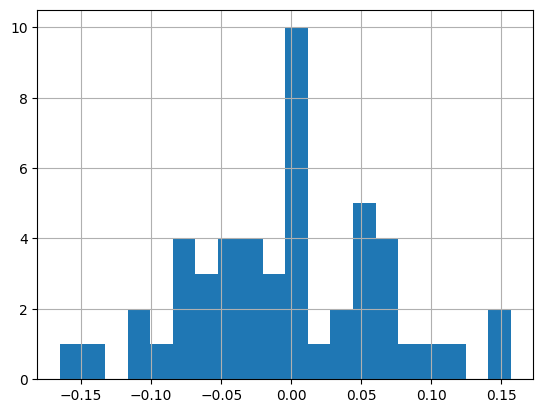

In [39]:
df['similarity_margin'].hist(bins=20)